# Mount Gdrive

In [1]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


In [3]:
import wandb
wandb.login(key='5157ae11e5d243722bc57912a56718dc8ef2f734') #Wandb login with my key
# 5157ae11e5d243722bc57912a56718dc8ef2f734

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Libraries

In [4]:
import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import glob
import re
import unicodedata
import string
import copy

In [5]:
from __future__ import unicode_literals, print_function, division
from io import open
from torch import optim
from torch.utils.data import DataLoader,Dataset
path = '/content/drive/MyDrive/DL/A3_Data/aksharantar_sampled/hin'

# Check for GPU

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Load

In [7]:
csv_files = glob.glob(os.path.join(path, "*.csv"))
# Sort the list of CSV file paths alphabetically
csv_files = sorted(csv_files)
print(csv_files)

['/content/drive/MyDrive/DL/A3_Data/aksharantar_sampled/hin/hin_test.csv', '/content/drive/MyDrive/DL/A3_Data/aksharantar_sampled/hin/hin_train.csv', '/content/drive/MyDrive/DL/A3_Data/aksharantar_sampled/hin/hin_valid.csv']


In [8]:
test_data=pd.read_csv(csv_files[0])
train_data=pd.read_csv(csv_files[1])
valid_data=pd.read_csv(csv_files[2])

display((valid_data))

,jaisawal,जयसवाल
0,bajai,बजाई
1,sanghthan,संघठन
2,haiwaan,हैवान
3,nilgiri,नीलगिरि
4,drutgrami,द्रुतग्रामी
...,...,...
4090,paranshu,परांशु
4091,romanchit,रोमांचित
4092,ekamreshwar,एकाम्रेश्वर
4093,bluetooth,ब्ल्यूटूथ


# Data processing

Dictionary  index =>character and character => index

In [9]:
# Data path
train_data_path=csv_files[1]

# Load the CSV file using pandas
train_data = pd.read_csv(train_data_path)

# Assuming the CSV file has two columns named 'source' and 'target'
# Extract the first row to determine the column names dynamically
first_row = train_data.iloc[0]

# Determine the column names dynamically
training_src = first_row.index[0]  # Assuming the first column is the source column
training_target = first_row.index[1]  # Assuming the second column is the target column

# Print the determined column names
print("Source Column:", training_src)
print("Target Column:", training_target)


Source Column: shastragaar
Target Column: शस्त्रागार


In [10]:
# Data path
test_data_path=csv_files[0]

# Load the CSV file using pandas
test_data = pd.read_csv(test_data_path)

# Assuming the CSV file has two columns named 'source' and 'target'
# Extract the first row to determine the column names dynamically
first_row = test_data.iloc[0]

# Determine the column names dynamically
test_src = first_row.index[0]  # Assuming the first column is the source column
test_target = first_row.index[1]  # Assuming the second column is the target column

# Print the determined column names
print("Source Column:", test_src)
print("Target Column:", test_target)


Source Column: thermax
Target Column: थरमैक्स


In [11]:

# Assume we want to process the first CSV file in the list
valid_data_path = csv_files[2]

# Load the CSV file using pandas
valid_data = pd.read_csv(valid_data_path)

# Assuming the CSV file has two columns named 'source' and 'target'
# Extract the first row to determine the column names dynamically
first_row = valid_data.iloc[0]

# Determine the column names dynamically
validation_src = first_row.index[0]  # Assuming the first column is the source column
validation_target = first_row.index[1]  # Assuming the second column is the target column

# Print the determined column names
print("Source Column:", validation_src)
print("Target Column:", validation_target)


Source Column: jaisawal
Target Column: जयसवाल


prep-rocessing data

In [12]:
# Text conversion to Lowercase
train_data[training_src] = train_data[training_src].str.lower()
test_data[test_src]=test_data[test_src].str.lower()
print(train_data[training_src].shape)
print(test_data[test_src].shape)

(51199,)
(4095,)


Data cleaning

In [13]:
def data_cleaning(text):
    my_text=text
    my_text = re.sub(r'[^\u0900-\u097F\s]', '', text) # Remove punctuations and digits
    my_text = re.sub(r'[\d]', '', my_text)
    target_vocab_size=58
    my_text = unicodedata.normalize('NFD', my_text)  # Normalize text
    my_text = ''.join(c for c in my_text if unicodedata.category(c) != 'Mn')
    text2=0
    my_text = unicodedata.normalize('NFC', my_text)
    return my_text

Tokenizing Train data

In [14]:
train_data[training_target] = train_data[training_target].apply(data_cleaning)
train_char_scr = set()
train_char_target = set()
for src, target in zip(train_data[training_src], train_data[training_target]):
    train_char_scr.update(src)
    train_char_target.update(target)

train_char_scr = sorted(list(train_char_scr))
train_char_target = sorted(list(train_char_target))


Tokenizing Test data

In [15]:
test_data[test_target]=test_data[test_target].apply(data_cleaning)
test_char_scr = set()
test_char_target = set()
for src, target in zip(test_data[test_src],test_data[test_target]):
    test_char_scr.update(src)
    test_char_target.update(target)
test_char_scr = sorted(list(test_char_scr))
test_char_target = sorted(list(test_char_target))


Tokenizing Valid data

In [16]:
valid_data[validation_target]=valid_data[validation_target].apply(data_cleaning)
val_char_scr = set()
print("A",test_char_target)
val_char_target = set()
for src, target in zip(valid_data[validation_src], valid_data[validation_target]):
    val_char_scr.update(src)
    val_char_target.update(target)
val_char_scr = sorted(list(val_char_scr))
print((train_char_target))
val_char_target = sorted(list(val_char_target))


A ['ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'ऽ', 'ा', 'ि', 'ी', 'ॉ', 'ॊ', 'ो', 'ौ']
['ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'ळ', 'व', 'श', 'ष', 'स', 'ह', 'ऽ', 'ा', 'ि', 'ी', 'ॉ', 'ो', 'ौ']


In [17]:
###character to index dictionary
cha_src=sorted(list(set().union(train_char_scr,test_char_scr,val_char_scr)))
print(train_data)
cha_target=sorted(list(set().union(train_char_target,test_char_target,val_char_target )))

char_to_index_src = {char: i for i, char in enumerate(cha_src)}
len1 = len(char_to_index_src)
char_to_index_target = {char: i for i, char in enumerate(cha_target)}
len2=len(char_to_index_target)
char_to_index_src['<SOS>'] = len1
char_to_index_target['<SOS>'] = len2
len3= len(char_to_index_src)
char_to_index_src['<EOS>'] =len3
len4=len(char_to_index_target)
char_to_index_target['<EOS>'] = len4
len5=len(char_to_index_src)
char_to_index_src['<PAD>'] = len5
len6=len(char_to_index_target)
char_to_index_target['<PAD>'] = len6
print(char_to_index_target)

## index to charcter dicitonary
index_to_char_src={i:char for i,char in enumerate(cha_src)}
print(char_to_index_src)
index_to_char_target={i:char for i,char in enumerate(cha_target)}

       shastragaar शस्त्रागार
0          bindhya     बिनदया
1        kirankant    किरणकात
2      yagyopaveet   यजञोपवीत
3          ratania    रटानिया
4       vaganyache    वागणयाच
...            ...        ...
51194        toned        टोड
51195   mutanaazaa     मतनाजा
51196    asahmaton     असहमतो
51197    sulgaayin     सलगायी
51198  anchuthengu       अचतग

[51199 rows x 2 columns]
{'ः': 0, 'अ': 1, 'आ': 2, 'इ': 3, 'ई': 4, 'उ': 5, 'ऊ': 6, 'ऋ': 7, 'ए': 8, 'ऐ': 9, 'ऑ': 10, 'ओ': 11, 'औ': 12, 'क': 13, 'ख': 14, 'ग': 15, 'घ': 16, 'ङ': 17, 'च': 18, 'छ': 19, 'ज': 20, 'झ': 21, 'ञ': 22, 'ट': 23, 'ठ': 24, 'ड': 25, 'ढ': 26, 'ण': 27, 'त': 28, 'थ': 29, 'द': 30, 'ध': 31, 'न': 32, 'प': 33, 'फ': 34, 'ब': 35, 'भ': 36, 'म': 37, 'य': 38, 'र': 39, 'ल': 40, 'ळ': 41, 'व': 42, 'श': 43, 'ष': 44, 'स': 45, 'ह': 46, 'ऽ': 47, 'ा': 48, 'ि': 49, 'ी': 50, 'ॉ': 51, 'ॊ': 52, 'ो': 53, 'ौ': 54, '<SOS>': 55, '<EOS>': 56, '<PAD>': 57}
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10,

In [18]:
def generate_token(src,target,path): #source: input column of csv file , target: target column of csv file

    data=pd.read_csv(path)
    data_val = [] # char to num val
    data[src] = data[src].str.lower()  # lowercase conversion of data
    data[target] = data[target].apply(data_cleaning)

    for src, targ in zip(data[src], data[target]):
        source_val = [char_to_index_src[char] for char in src]
        temp1=[char_to_index_src['<EOS>']]
        source_val=[char_to_index_src['<SOS>']] + temp1 + source_val + [char_to_index_src['<PAD>']] * (28-len(src)-2)
        target_val = [char_to_index_target[char] for char in targ]
        temp2=target_val+[char_to_index_target['<EOS>']]
        target_val=[char_to_index_target['<SOS>']]+temp2+[char_to_index_target['<PAD>']]*(20-len(targ)-2)
        data_val.append([source_val, target_val])

    return data_val

# Class AksharantarDataset is for making tokenized data iteratable

In [19]:
class data_preprocess(Dataset):
    def __init__(self, data):
        """
        Initialize the dataset with the provided data.

        Args:
            data (list): List of tuples containing source and target data.
        """
        self.data = data

    def __len__(self):
        """
        Get the total number of samples in the dataset.

        Returns:
            int: Total number of samples.
        """
        return len(self.data)

    def __getitem__(self, index):
        ind_=0
        """
        Retrieve a specific sample from the dataset.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            tuple: Tuple containing the source tensor and target tensor.
        """
        src, target = self.data[index]
        ind_=ind_+1
        src_tensor = torch.tensor(src, dtype=torch.long)
        target_tensor = torch.tensor(target, dtype=torch.long)
        return src_tensor, target_tensor

# Dataloading

In [20]:
data_train=DataLoader(data_preprocess(generate_token(training_src,training_target,train_data_path)), batch_size=64, shuffle=True)
data_val=DataLoader(data_preprocess(generate_token(validation_src,validation_target,valid_data_path)), batch_size=64, shuffle=False)
data_test=DataLoader(data_preprocess(generate_token(test_src,test_target,test_data_path)), batch_size=64, shuffle=False)
print(len(data_train))
print(len(data_val))
print(len(data_test))

800
64
64


# Model

Parameters used:
     # input embedding size => length of input to encoder
     # embedding size => embedding length for each character in embedding layer
     # hidden layer size => hidden size of encoder hidden states
     # number of encoder layers => number of encoder layer in encoder
     # dropout => dropout ratio appied in fc layer
     # bidirectional => [True,False]
     # cell type => 'LSTM','RNN','GRU'


# Encoder

forward propogation for encoder

In [21]:
# def forward_encoder(num_encoder_layer, hidden_size, bidirection, cell_type, embedding, rnn, dropout, inputs):
#     # Determine device (assuming 'device' is defined elsewhere)
#     device = inputs.device

#     # Initialize initial hidden states based on bidirection and cell_type
#     if bidirection:
#         num_directions = 2
#     else:
#         num_directions = 1

#     num_layers = num_encoder_layer * num_directions

#     if cell_type == 'LSTM':
#         h0 = torch.randn(num_layers, inputs.shape[0], hidden_size).to(device)
#         c0 = torch.randn(num_layers, inputs.shape[0], hidden_size).to(device)
#         initial_state = (h0, c0)
#     else:
#         h0 = torch.randn(num_layers, inputs.shape[0], hidden_size).to(device)
#         initial_state = h0

#     # Apply dropout to the input embeddings
#     embedded_inputs = dropout(embedding(inputs))
#     embedded_inputs = embedded_inputs.permute(1, 0, 2)  # Change input shape for RNN

#     # Forward pass through RNN
#     if cell_type == 'LSTM':
#         output, (hidden, cell) = rnn(embedded_inputs, initial_state)
#         return hidden, cell
#     else:
#         output, hidden = rnn(embedded_inputs, initial_state)
#         #cell = None  # No cell state for non-LSTM RNNs
#         return hidden, None


In [22]:
# def forward_decoder(embedding, rnn, dropout, fc, cell_type, x, hidden, cell):
#     # Prepare input tensor for the decoder
#     x = x.unsqueeze(0)
#     embedded_input = dropout(embedding(x))

#     if cell_type == 'LSTM':
#         # Apply the LSTM decoder with cell state
#         output, (hidden, cell) = rnn(embedded_input, (hidden, cell))
#     else:
#         # Apply the GRU or RNN decoder without cell state
#         output, hidden = rnn(embedded_input, hidden)
#         cell = None  # Set cell to None for consistency

#     # Perform fully connected layer operation for prediction
#     prediction = fc(output)
#     prediction = prediction.squeeze(0)  # Remove the extra dimension

#     return prediction, hidden, cell


In [23]:
# class encoder(nn.Module):
#     def __init__(self,input_size,embedding_size,hidden_size,num_encoder_layer,dropout,input_vocab_size,bidirection,cell_type):
#         super(encoder,self).__init__()

#         self.cell_type=cell_type
#         rnn_dict = {
#         'GRU': nn.GRU,
#         'RNN': nn.RNN,
#         'LSTM': nn.LSTM
#         }
#         self.num_encoder_layer=num_encoder_layer
#         self.embedding=nn.Embedding(input_vocab_size,embedding_size)
#         # Determine the RNN class based on the specified cell_type
#         rnn_class = rnn_dict[cell_type]
#         self.bidirection=bidirection    #self.embedding_size = embeddings_size
#         self.hidden_size=hidden_size
#         self.dropout=nn.Dropout(dropout)
#         self.input_size = input_size


#     # Validate the cell_type
#         if cell_type not in rnn_dict:
#             raise ValueError(f"Invalid cell_type: {cell_type}. Supported types are {list(rnn_dict.keys())}")


#     # Check if num_encoder_layer is not equal to 1 to include dropout and bidirectional
#         if num_encoder_layer != 1:
#             self.rnn = rnn_class(embedding_size, hidden_size, num_encoder_layer,dropout=dropout, bidirectional=bidirection)
#         else:
#             self.rnn = rnn_class(embedding_size, hidden_size, num_encoder_layer,bidirectional=bidirection)


#     def forward(self,inputs):
#         return forward_encoder(self.num_encoder_layer ,self.hidden_size,self.bidirection,self.cell_type ,self.embedding,self.rnn , self.dropout , inputs  )


# Decoder

forward propogation for decoder

In [24]:
# class Decoder(nn.Module):
#     def __init__(self,input_size,embedding_size,hidden_size,output_vocab_size,num_decoder_layer,dropout,bidirection,cell_type):

#         super(Decoder,self).__init__()
#         self.cell_type=cell_type
#         self.embedding=nn.Embedding(output_vocab_size+3,embedding_size)
#         self.dropout=nn.Dropout(dropout)
#         self.num_decoder_layer=num_decoder_layer
#         self.hidden_size=hidden_size

#         rnn_dict = {
#             'GRU': nn.GRU,
#             'RNN': nn.RNN,
#             'LSTM': nn.LSTM
#         }

#         # Validate the cell_type
#         if cell_type not in rnn_dict:
#             raise ValueError(f"Invalid cell_type: {cell_type}. Supported types are {list(rnn_dict.keys())}")

#         # Determine the RNN class based on the specified cell_type
#         rnn_class = rnn_dict[cell_type]

#         # Check if num_encoder_layer is not equal to 1 to include dropout and bidirectional
#         if num_decoder_layer != 1:
#             rnn_class = rnn_dict[cell_type]
#             self.rnn = rnn_class(embedding_size, hidden_size, num_decoder_layer,dropout=dropout, bidirectional=bidirection)
#         else:
#             rnn_class = rnn_dict[cell_type]
#             self.rnn = rnn_class(embedding_size, hidden_size, num_decoder_layer,bidirectional=bidirection)

#         # bidirectional if used
#         if bidirection:
#             temp1=output_vocab_size+3
#             temp2=hidden_size*2
#             self.fc=nn.Linear(temp2,temp1)

#         else:
#             temp3=output_vocab_size+3
#             self.fc=nn.Linear(hidden_size,temp3)


#     def forward(self,x,hidden,cell):
#         return forward_decoder(self.embedding , self.rnn , self.dropout , self.fc , self.cell_type , x,hidden,cell)

# Seq2seq model : connecting encoder and decoder to generate the output

In [25]:
# class seq2seq(nn.Module):
#     def __init__(self,encoder,decoder):
#         super(seq2seq,self).__init__()
#         self.encoder=encoder
#         target_vocab_size=58
#         self.decoder=decoder

#   #forward propogation
#     def forward(self,source,target,teacher_forceing=0.5):
#         self.target=target
#         batch_size=source.shape[0]
#         target_vocab_size=58
#         self.target_len=target.shape[1]

#         outputs=torch.zeros(self.target_len,batch_size,target_vocab_size).to(device)

#         hidden,cell=self.encoder(source)
#         x=target[:,0]


#         for t in range(0,self.target_len):
#             pred,hidden,cell=self.decoder(x,hidden,cell)
#             outputs[t]=pred
#             target_vocab_size=58
#             best_guess=pred.argmax(1)
#             target_vocab_size=58
#             x=target[:,t] if random.random()<teacher_forceing else best_guess
#         return outputs


#     def prediction(self,sources):
#         outputs=torch.zeros(self.target_len,sources.shape[0],58).to(device)
#         hidden,cell=self.encoder(sources)
#         x=sources[:,0]


#         for t in range(0,self.target_len):

#             pred,hidden,cell=self.decoder(x,hidden,cell)
#             outputs[t]=pred
#             target_vocab_size=58
#             best_guess=pred.argmax(1)
#             x=best_guess
#         return outputs

In [26]:
def forward_encoder(num_encoder_layer,hidden_size , bidirection,embedding, rnn, dropout, inputs):
    batch_size=inputs.shape[0]

    if bidirection:
        h0=torch.randn(2*num_encoder_layer,batch_size,hidden_size).to(device)
    else:
        h0=torch.randn(num_encoder_layer,batch_size,hidden_size).to(device)

    embedding=dropout(embedding(inputs))
    embedding=torch.permute(embedding,(1,0,2))
    encoder_states,hidden=rnn(embedding,h0)
    return encoder_states,hidden
# ////////////////////////////////////////////
class Encoder(nn.Module):
    def __init__(self,input_size,embedding_size,hidden_size,num_encoder_layer,dropout,input_vocab_size,bidirection,cell_type):
        super(Encoder,self).__init__()
        self.input_size = input_size
        self.cell_type=cell_type
        self.bidirection=bidirection
        self.hidden_size=hidden_size
        self.num_encoder_layer=num_encoder_layer
        self.dropout=nn.Dropout(dropout)
        self.embedding=nn.Embedding(input_vocab_size,embedding_size)

        rnn_dict = {
            'GRU': nn.GRU,
            'RNN': nn.RNN,
            'LSTM': nn.LSTM
            }

        if cell_type not in rnn_dict:
            raise ValueError(f"Invalid cell_type: {cell_type}. Supported types are {list(rnn_dict.keys())}")

        rnn_class = rnn_dict[cell_type]

        if num_encoder_layer != 1:
            self.rnn = rnn_class(embedding_size, hidden_size, num_encoder_layer,dropout=dropout, bidirectional=bidirection)
        else:
            self.rnn = rnn_class(embedding_size, hidden_size, num_encoder_layer,bidirectional=bidirection)

    def forward(self,inputs):
         return forward_encoder(self.num_encoder_layer, self.hidden_size, self.bidirection, self.embedding, self.rnn, self.dropout, inputs)

# //////////////////////////////
class Decoder_Attn(nn.Module):
    def __init__(self,input_size,embedding_size,hidden_size,output_vocab_size,num_decoder_layer,dropout,bidirection,cell_type):
        super(Decoder_Attn,self).__init__()
        self.bidirection=bidirection
        self.hidden_size=hidden_size
        self.cell_type=cell_type
        self.num_layer=num_decoder_layer
        self.dropout=nn.Dropout(dropout)
        self.embedding=nn.Embedding(output_vocab_size+3,embedding_size)


        rnn_dict = {
            'GRU': nn.GRU,
            'RNN': nn.RNN,
            'LSTM': nn.LSTM
            }
        rnn_class = rnn_dict[cell_type]


        if self.bidirection:
            if cell_type=='GRU':
                if num_decoder_layer!=1:
                    self.rnn=rnn_class(hidden_size*2+embedding_size,hidden_size,num_decoder_layer,dropout=dropout,bidirectional=bidirection)
                else:
                    self.rnn=rnn_class(hidden_size*2+embedding_size,hidden_size,num_decoder_layer,bidirectional=bidirection)
            self.energy=nn.Linear(hidden_size*3,1)
        else:
            if cell_type=='GRU':
                if num_decoder_layer!=1:
                    self.rnn=rnn_class(hidden_size+embedding_size,hidden_size,num_decoder_layer,dropout=dropout,bidirectional=bidirection)
                else:
                    self.rnn=rnn_class(hidden_size+embedding_size,hidden_size,num_decoder_layer,bidirectional=bidirection)
            self.energy=nn.Linear(hidden_size*2,1)

        self.softmax=nn.Softmax(dim=0)
        self.tanh=nn.Tanh()
        if bidirection:
            self.fc=nn.Linear(hidden_size*2,output_vocab_size+3)
        else:
            self.fc=nn.Linear(hidden_size,output_vocab_size+3)


    def forward(self,x,encoder_states,hidden):
        x=x.unsqueeze(0)
        embedding=self.dropout(self.embedding(x))
        seq_length=encoder_states.shape[0]
        if self.bidirection:
            h_reshaped=hidden.repeat((seq_length//(2*self.num_layer)),1,1)
        else:
            h_reshaped=hidden.repeat((seq_length//(self.num_layer)),1,1)
        energy=self.tanh(self.energy(torch.cat((h_reshaped,encoder_states),dim=2)))
        attention=self.softmax(energy)
        attention=attention.permute(1,2,0)
        encoder_states=encoder_states.permute(1,0,2)
        context_vector=torch.bmm(attention,encoder_states)
        context_vector=context_vector.permute(1,0,2)
        rnn_input=torch.cat((context_vector,embedding),dim=2)
        output,(hidden)=self.rnn(rnn_input,(hidden))
        prediction=self.fc(output)
        prediction=prediction.squeeze(0)
        return prediction,hidden



# ////////////////////////////
class seq2seq(nn.Module):
    def __init__(self,encoder,decoder):
        super(seq2seq,self).__init__()
        self.encoder=encoder
        self.decoder=decoder

    def forward(self,source,target,teacher_forceing=0.5):
        batch_size=source.shape[0]#64
        self.target=target
        self.target_len=target.shape[1]#20

        target_vocab_size=55
        outputs=torch.zeros(self.target_len,batch_size,target_vocab_size+3).to(device)

        encoder_states,hidden=self.encoder(source)
        x=target[:,0] #


        for t in range(0,self.target_len):
            pred,hidden=self.decoder(x,encoder_states,hidden)
            outputs[t]=pred
            best_guess=pred.argmax(1)
            x=target[:,t] if random.random()<teacher_forceing else best_guess
        return outputs


    def prediction(self,sources):
        batch_size=sources.shape[0]
        target_vocab_size=55
        outputs=torch.zeros(self.target_len,batch_size,target_vocab_size+3).to(device)
        encoder_states,hidden=self.encoder(sources)
        x=sources[:,0]

        for t in range(0,self.target_len):
            pred,hidden=self.decoder(x,encoder_states,hidden)
            outputs[t]=pred
            best_guess=pred.argmax(1)
            x=best_guess
        return outputs

# Sweep configuration over Hyperparameters

In [27]:
sweep_configuration={

    'name':'cs23m013',
    'method':'bayes',
    'metric':{'name':'val_acc','goal':'maximize'},
    'parameters':{

        'epochs':{
            'values':[1]
        },

         'learning_rate':{
            'values':[0.001 , 0.0001 , 0.00001]
        },

        'embedding_size':{
            'values':[64,128,256]
            },

        'num_encoder_layer':{
            'values':[1,2]
            },

        'num_decoder_layer':{
            'values':[1,2]
        },

        'hidden_layer_size':{
            'values':[64,128 , 256,512]
            },

        'cell_type':{
            'values':['GRU']
            },

        'dropout':{
            'values':[0, 0.2,0.3 , 0.4 , 0.6]
            },

        'bidirection':{
            'values':[True,False]
            }

        }
    }


# Train

In [28]:
def initialize_wandb():
    wandb.init()

# Call Sweep

In [29]:
#print and wandb log
def wandb_log_final(train_accuracy_char ,  train_loss , val_accuracy_word,val_loss):
    wandb.log({
        'train_accuracy_char': train_accuracy_char,
        'train_loss': train_loss,
        'val_accuracy_word': val_accuracy_word,
        'val_loss': val_loss
    })


In [30]:
def train_best_final(model, data_loader, criterion, optimizer, device, batch_size):
    model.train()
    train_loss = 0.0
    num_correct_train_char = 0

    for inputs, target in data_loader:
        inputs = inputs.to(device)
        crite_rion=0
        target = target.to(device)
        optimizer.zero_grad()

        output = model(inputs, target)
        output = torch.permute(output, (1, 0, 2))
        output3=crite_rion+1

        output1 = output[1:].reshape(-1, output.shape[2])
        target_vocab_size=58
        target1 = target[1:].reshape(-1)
        loss = criterion(output1, target1)
        output3=crite_rion+1
        loss.backward()
        target_vocab_size=58
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        train_loss =train_loss + loss.item()
        predict = F.softmax(output, dim=1)
        predictionss = torch.argmax(predict, dim=2)
        num_correct_train_char =  num_correct_train_char + (predictionss == target).sum().item()

    train_accuracy_char = (num_correct_train_char/(len(data_loader)*batch_size*20))
    train_accuracy_char=train_accuracy_char*100
    train_loss = (train_loss/(len(data_loader)*batch_size))
    train_loss=train_loss*100

    return train_loss, train_accuracy_char

In [31]:
# Validation function
def evaluate_best_final(model, data_loader, criterion, device, batch_size , index_to_char_target):
    model.eval()
    val_loss = 0.0
    val_l_oss=[]
    num_correct_val_char = 0
    train_l_oss=[]
    num_correct_val_word = 0

    with torch.no_grad():
        for i, (inputs, target) in enumerate(data_test):
            inputs=inputs.to(device)
            crite_rion=0
            target=target.to(device)

            output = model.prediction(inputs)
            output=torch.permute(output,(1,0,2))
            output1=output[1:].reshape(-1,output.shape[2])
            output2=crite_rion+1
            target1=target[1:].reshape(-1)
            loss = criterion(output1, target1)
            val_loss = val_loss +  loss.item()

            predictionss=torch.argmax(output,dim=2)
            num_correct_val_char = num_correct_val_char + (predictionss == target).sum().item()

            for j in range(len(predictionss)):
              predicted_sentence = ''
              target_sentence = ''
              for k in range(len(predictionss[j])):
                  if (predictionss[j][k].item()!=55):
                    if(predictionss[j][k].item()!=56):
                      if(predictionss[j][k].item()!=57):
                        predicted_sentence = predicted_sentence + index_to_char_target[predictionss[j][k].item()]
                  if (target[j][k].item()!=55):
                    if(target[j][k].item()!=56):
                      if(target[j][k].item()!=57):
                        target_sentence = target_sentence +  index_to_char_target[target[j][k].item()]
              if predicted_sentence==target_sentence:
                  num_correct_val_word= num_correct_val_word + 1

        val_accuracy_char=(num_correct_val_char/(len(data_test)*batch_size*20))
        val_loss=(val_loss/(len(data_test)*batch_size))
        val_accuracy_char=val_accuracy_char*100
        val_loss=val_loss*100
        val_accuracy_word=(num_correct_val_word/(len(data_test)*batch_size))
        val_accuracy_word=val_accuracy_word*100

    return val_loss, val_accuracy_char, val_accuracy_word

In [32]:
def build_best_model_final(config):

    input_vocab_size=29
    cell_type = config.cell_type

    encoder_embedding_size = config.embedding_size
    epochs = config.epochs
    input_size_decoder=20
    decoder_embedding_size = config.embedding_size
    input_size_encoder=28

    dec_dropout = config.dropout
    num_encoder_layers = config.num_encoder_layer
    learning_rate = config.learning_rate
    num_decoder_layers = config.num_encoder_layer
    output_vocab_size=55
    enc_dropout = config.dropout
    bidirection = config.bidirection
    hidden_size = config.hidden_layer_size

    run_name="ct_{}_ees_{}_lr_{}_des_{}_hs_{}_el_{}_dl_{}_ed_{}_dd_{}_bd_{}_ep_{}".format(cell_type , encoder_embedding_size,learning_rate , decoder_embedding_size,hidden_size,num_encoder_layers,num_decoder_layers,enc_dropout,dec_dropout,bidirection, epochs)
    # print("run_name:",run_name)

    encoder_net=Encoder(input_size_encoder,encoder_embedding_size,hidden_size,num_encoder_layers,enc_dropout,input_vocab_size,bidirection,'GRU').to(device)
    print("run_name:",run_name)
    decoder_net=Decoder_Attn(input_size_decoder,decoder_embedding_size,hidden_size,output_vocab_size,num_decoder_layers,dec_dropout,bidirection,'GRU').to(device)

    # Create Seq2Seq model
    model = seq2seq(encoder_net, decoder_net).to(device)
    return model , run_name


In [33]:
# Main training loop
def train_loop_best_final(val_Acc_char , model, train_loader, val_loader, criterion, optimizer, device, config, index_to_char_target, run_name , batch_size , val_Acc_word ,train_Acc_char , val_Loss , train_Loss):


    for epoch in range(config.epochs):
        train_loss, train_accuracy_char = train_best_final(model, train_loader, criterion, optimizer, device , batch_size)
        val_loss, val_accuracy_char, val_accuracy_word = evaluate_best_final(model, val_loader, criterion, device,batch_size, index_to_char_target)

        train_Loss.append(train_loss)
        train_Acc_char.append(train_accuracy_char)
        val_Loss.append(val_loss)
        val_Acc_char.append(val_accuracy_char)
        val_Acc_word.append(val_accuracy_word)

        print(f'Epoch [{epoch + 1}/{config.epochs}]')

        print("train_accuracy_char:",train_accuracy_char)
        print("train_loss:",train_loss)
        print("val_accuracy_word:",val_accuracy_word)
        print("val_loss:", val_loss)
        print("")

        # Logging using Weights & Biases
        wandb_log_final(train_accuracy_char ,  train_loss , val_accuracy_word ,val_loss)


    print("train_accuracy_char:", np.max(train_Acc_char))
    print("train_loss:", np.min(train_Loss))
    print("val_accuracy_word:", np.max(val_Acc_word))
    print("val_loss:", np.min(val_Loss))

    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()

In [34]:
def train_final():
    initialize_wandb()
    val_Acc_char=[]
    batch_size = 64
    val_Loss=[]
    load_model = True
    train_Acc_char=[]
    config = wandb.config
    model,run_name = build_best_model_final(config)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion=nn.CrossEntropyLoss()
    train_Loss=[]
    best_accuracy=0
    val_Acc_word = []
    train_loop_best_final(val_Acc_char , model, data_train, data_val, criterion, optimizer, device, config, index_to_char_target, run_name , batch_size ,val_Acc_word , train_Acc_char , val_Loss , train_Loss)

In [35]:
# sweep_id=wandb.sweep(sweep=sweep_configuration,entity="cs23m013",project='DL_A3_Attn')
# wandb.agent(sweep_id,function=train_final,count=1)
# wandb.finish()

#Train with Best parameters

In [36]:
def train_best(model, data_loader, criterion, optimizer, device, batch_size):
    model.train()
    train_loss = 0.0
    num_correct_train_char = 0

    for inputs, target in data_loader:
        inputs = inputs.to(device)
        target = target.to(device)
        optimizer.zero_grad()

        output = model(inputs, target)
        output = torch.permute(output, (1, 0, 2))
        output1 = output[1:].reshape(-1, output.shape[2])

        target1 = target[1:].reshape(-1)

        loss = criterion(output1, target1)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

        train_loss += loss.item()
        predict = F.softmax(output, dim=1)
        predictionss = torch.argmax(predict, dim=2)

        num_correct_train_char += (predictionss == target).sum().item()

    train_accuracy_char = (num_correct_train_char/(len(data_loader)*batch_size*20))*100
    train_loss = (train_loss/(len(data_loader)*batch_size))*100

    return train_loss, train_accuracy_char


In [37]:

# Validation function
def evaluate_best(model, data_loader, criterion, device, batch_size , index_to_char_target):
    model.eval()
    val_loss = 0.0
    num_correct_val_char = 0
    num_correct_val_word = 0

    with torch.no_grad():
        for i, (inputs, target) in enumerate(data_test):
            inputs=inputs.to(device)
            target=target.to(device)
            output = model.prediction(inputs)
            output=torch.permute(output,(1,0,2))
            output1=output[1:].reshape(-1,output.shape[2])
            target1=target[1:].reshape(-1)
            loss = criterion(output1, target1)
            val_loss += loss.item()
            predictionss=torch.argmax(output,dim=2)
            num_correct_val_char += (predictionss == target).sum().item()

            for j in range(len(predictionss)):
                predicted_sentence = ''
                target_sentence = ''
                for k in range(len(predictionss[j])):
                    if (predictionss[j][k].item()!=55 and predictionss[j][k].item()!=56 and predictionss[j][k].item()!=57):
                        predicted_sentence += index_to_char_target[predictionss[j][k].item()]
                    if (target[j][k].item()!=55 and target[j][k].item()!=56 and target[j][k].item()!=57 ):
                        target_sentence += index_to_char_target[target[j][k].item()]
                if predicted_sentence==target_sentence:
                    num_correct_val_word+=1

        val_loss=(val_loss/(len(data_test)*batch_size))*100
        val_accuracy_char=(num_correct_val_char/(len(data_test)*batch_size*20))*100
        val_accuracy_word=(num_correct_val_word/(len(data_test)*batch_size))*100

    return val_loss, val_accuracy_char, val_accuracy_word

In [38]:
def build_best_model():

    batch_size=64
    load_model=True
    epochs=1
    learning_rate=0.0001
    input_size_encoder=28
    input_size_decoder=20
    input_vocab_size=29
    output_vocab_size=55
    cell_type='GRU'
    encoder_embedding_size=256
    decoder_embedding_size=256
    hidden_size=512
    num_encoder_layers=2
    num_decoder_layers=2
    enc_dropout=0.3
    dec_dropout=0.3
    bidirection=True


    encoder_net=Encoder(input_size_encoder,encoder_embedding_size,hidden_size,num_encoder_layers,enc_dropout,input_vocab_size,bidirection,cell_type).to(device)
    decoder_net=Decoder_Attn(input_size_decoder,decoder_embedding_size,hidden_size,output_vocab_size,num_decoder_layers,dec_dropout,bidirection,cell_type).to(device)

    # Create Seq2Seq model
    model = seq2seq(encoder_net, decoder_net).to(device)

    return model

In [39]:
# Main training loop
def train_loop_best(model, train_loader, val_loader, criterion, optimizer, device, index_to_char_target , best_accuracy):
    batch_size=64
    load_model=True
    epochs=1
    learning_rate=0.0001
    input_size_encoder=28
    input_size_decoder=20
    input_vocab_size=29
    output_vocab_size=55
    cell_type='GRU'
    encoder_embedding_size=256
    decoder_embedding_size=256
    hidden_size=512
    num_encoder_layers=2
    num_decoder_layers=2
    enc_dropout=0.3
    dec_dropout=0.3
    bidirection=True

    val_Loss = []
    train_Loss = []
    val_Acc_char = []
    val_Acc_word = []
    train_Acc_char = []

    for epoch in range(epochs):
        train_loss, train_accuracy_char = train_best(model, train_loader, criterion, optimizer, device , batch_size)
        val_loss, val_accuracy_char, val_accuracy_word = evaluate_best(model, val_loader, criterion, device,batch_size, index_to_char_target)

        train_Loss.append(train_loss)
        train_Acc_char.append(train_accuracy_char)
        val_Loss.append(val_loss)
        val_Acc_char.append(val_accuracy_char)
        val_Acc_word.append(val_accuracy_word)

        print(f'Epoch [{epoch + 1}/{epochs}]')

        print("train_accuracy_char:",train_accuracy_char)
        print("train_loss:",train_loss)
        print("val_accuracy_word:",val_accuracy_word)
        print("val_loss:", val_loss)
        print("")

        if val_accuracy_char>best_accuracy:
            torch.save(model.state_dict(),'best_checkpoint.model')
            model_wts=copy.deepcopy(model.state_dict())
            best_accuracy=val_accuracy_char


    print("train_accuracy_char:", np.max(train_Acc_char))
    print("train_loss:", np.min(train_Loss))
    print("val_accuracy_word:", np.max(val_Acc_word))
    print("val_loss:", np.min(val_Loss))

    plt.plot(train_Loss, 'r', label="Training loss")
    plt.plot(val_Loss, 'lime', label="Validation loss")
    plt.title("Training and Validation Loss vs Number of Epochs", size=15)
    plt.xlabel("Number of epochs", size=15)
    plt.ylabel("Loss", size=15)
    plt.legend()
    plt.show()
    plt.plot(train_Acc_char, 'r', label="Training Accuracy char")
    plt.plot(val_Acc_word ,'lime', label="Validation Accuracy word")
    plt.plot(val_Acc_char ,'b', label="Validation Accuracy char")
    plt.title("Training and Validation Accuracy vs Number of Epochs", size=15)
    plt.xlabel("Number of epochs", size=15)
    plt.ylabel("Accuracy", size=15)
    plt.legend()
    plt.show()

    model.load_state_dict(model_wts)
    return model

In [40]:
def train_best_model():
    model = build_best_model()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion=nn.CrossEntropyLoss()
    best_accuracy=0
    return train_loop_best(model, data_train, data_val, criterion, optimizer, device, index_to_char_target , best_accuracy)

Epoch [1/1]
train_accuracy_char: 50.36640625
train_loss: 1.2996846989844926
val_accuracy_word: 13.134765625
val_loss: 0.9006804575619753

train_accuracy_char: 50.36640625
train_loss: 1.2996846989844926
val_accuracy_word: 13.134765625
val_loss: 0.9006804575619753


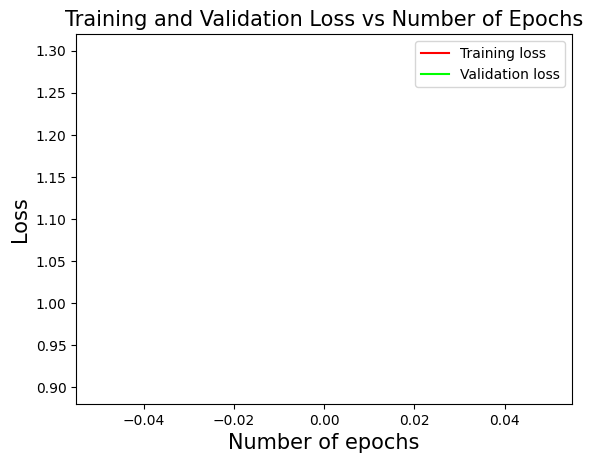

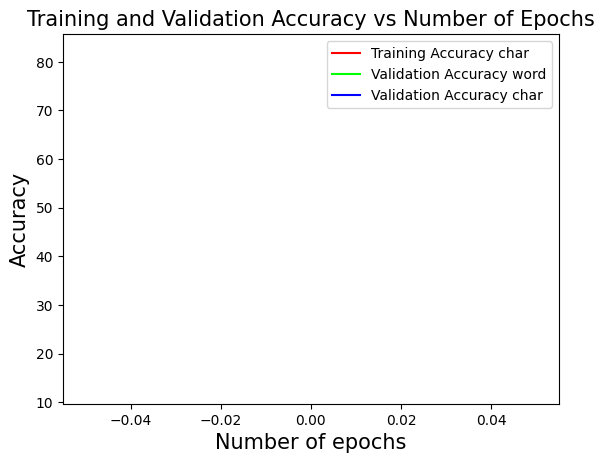

In [41]:
best_model=train_best_model()

# Predicting word by trained model and saving in csv file

In [42]:
prediction_out_list=[]
correct_prediction_out_list=[]

for i, (inputs, target) in enumerate(data_test):
    inputs=inputs.to(device)
    target=target.to(device)
    output = best_model.prediction(inputs)
    output=torch.permute(output,(1,0,2))
    predict=F.softmax(output,dim=1)
    predictionss=torch.argmax(predict,dim=2)

    for j in range(len(predictionss)):
        predicted_word = ''
        target_word = ''
        source_word=''

        for k in range(len(target[j])):
            if (target[j][k].item()!=55  and target[j][k].item()!=57):
                if target[j][k].item()!=56:
                    target_word += index_to_char_target[target[j][k].item()]
                else:
                    break

        for k in range(len(inputs[j])):
            if (inputs[j][k].item()!=26  and inputs[j][k].item()!=28):
                if inputs[j][k].item()!=27:
                    source_word+=index_to_char_src[inputs[j][k].item()]
                else:
                    break


        for k in range(len(predictionss[j])):
            if (predictionss[j][k].item()!=55  and predictionss[j][k].item()!=57):
                if predictionss[j][k] != 56:
                    predicted_word += index_to_char_target[predictionss[j][k].item()]
                else:
                    break

        prediction_out_list.append([source_word,predicted_word,target_word])

        if (predicted_word==target_word):
            correct_prediction_out_list.append([source_word,predicted_word,target_word])


#---------------------------

files= pd.DataFrame(np.array(prediction_out_list),columns = ["Source","Predicted","Target"])
files.to_csv("Prediction.csv", index = False)

#----------------------------

# reading the csv file
cvsDataframe = pd.read_csv('Prediction.csv')

# creating an output excel file
resultExcelFile = pd.ExcelWriter('Result.xlsx')

# converting the csv file to an excel file
cvsDataframe.to_excel(resultExcelFile, index=False)

# saving the excel file
resultExcelFile.close()

# Reading and Converting the output/result excel file into a dataframe object
excelDataframe=pd.read_excel('Result.xlsx')

print(excelDataframe)

      Source Predicted    Target
0        NaN    सिखागा   सिखाएगा
1        NaN      लारन       लरन
2        NaN    तिियरस    टविटरस
3        NaN   तिरणलवी  तिरनलवली
4        NaN    इडनपीक    इडिपडस
...      ...       ...       ...
4090     NaN     सललथा     सफलता
4091     NaN     शबनना     शबाना
4092     NaN   खौटोपाओ   खातटोला
4093     NaN   शिवासता   शिवासतव
4094     NaN   परणणजयी  पररणापरी

[4095 rows x 3 columns]


In [44]:
# Load the CSV file
predicted_data = pd.read_csv("/content/Prediction.csv")
Prediction_table = wandb.Table(dataframe=predicted_data)

# Add the table to an Artifact to increase the row
# limit to 200000 and make it easier to reuse
data_table_artifact = wandb.Artifact(
    "predictions_vanilla", type="dataset")

data_table_artifact.add(Prediction_table,"Correct_Predictions")

# Log the raw csv file within an artifact to preserve our data
data_table_artifact.add_file("/content/Prediction.csv")


ArtifactManifestEntry(path='Prediction.csv', digest='m5ImITkm0cDV29HlyNKKVg==', size=147819, local_path='/root/.local/share/wandb/artifacts/staging/tmpoxzgze30', skip_cache=False)

In [ ]:
run = wandb.init(project='DL_A3_Attn')
# Log the table to visualize with a run...
run.log({"Correct_Predictions_Table": Prediction_table})

# and Log as an Artifact to increase the available row limit!
run.log_artifact(data_table_artifact)


# HeatMap

In [ ]:
# def plot_attention_weights(input_sequence, output_sequence, encoder_model, decoder_model):
#     enc_input = np.array([input_sequence])
#     enc_output, enc_state_h, enc_state_c = encoder_model.predict(enc_input)
    
#     dec_input = np.array([[output_sequence[0]]])  # start decoding with the start token
#     attention_weights = []
    
#     for t in range(1, len(output_sequence)):
#         dec_output, attention, dec_state_h, dec_state_c = decoder_model.predict([dec_input, enc_output, enc_state_h, enc_state_c])
#         attention_weights.append(attention.flatten())
#         predicted_token = np.argmax(dec_output, axis=-1)
#         dec_input = np.array([[predicted_token[0][0]]])  # feed the predicted token as input to the next time step
    
#     attention_weights = np.array(attention_weights)
    
#     plt.figure(figsize=(10, 5))
#     plt.imshow(attention_weights.T, cmap='viridis')
#     plt.xlabel('Decoder timestep')
#     plt.ylabel('Encoder timestep')
#     plt.title('Attention Heatmap')
#     plt.colorbar()
#     plt.show()


# for i in range(9):
#     input_seq = df_test.iloc[i, 0][:-1]  # Extract input sequence from DataFrame
#     output_seq = df_test.iloc[i, 1][:-1]
#     predicted_output, attention = predict(model, input_seq, input_char_to_int, output_char_to_int, output_int_to_char)
#     attention = attention[:, :, :(len(input_seq))]
#     inputs.append(input_seq)
#     outputs.append(output_seq)
#     attentions.append(attention)

# encoder_net=Encoder(input_size_encoder,encoder_embedding_size,hidden_size,num_encoder_layers,enc_dropout,input_vocab_size,bidirection,cell_type).to(device)
# decoder_net=Decoder_Attn(input_size_decoder,decoder_embedding_size,hidden_size,output_vocab_size,num_decoder_layers,dec_dropout,bidirection,cell_type).to(device)

# decoder_state_inputs = [Input(shape=(hidden_units,)), Input(shape=(hidden_units,))]
# decoder_outputs, attention, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_state_inputs)

# plot_attention_weights(input_sequence, output_sequence, encoder_model, decoder_model)
